In [7]:
%matplotlib inline
import pybedtools
from matplotlib_venn import venn2, venn3
import pandas as pd
import os
from gscripts.general import dataviz
img_dir = "/home/gpratt/Dropbox/293-G3BP-TIA-eCLIP/overlapping_peaks/"

from gscripts import GO


In [3]:
df = pd.read_table("/home/elvannostrand/data/clip/CLIPseq_analysis/SM_v9_20151211/encode_v9_filelist_SM_20151211.txt.l2foldenr_files.txt",
              header=None, names=['encode_id', 
                                   'rbp', 
                                   'cell_type', 
                                   'bam_file_1', 
                                   'bam_file_2', 
                                   'input_file', 
                                   'peaks_file_1', 
                                   'peaks_file_2'])


#tidy the data up
result = []
for index, line in df.iterrows():
    result.append({'encode_id': line.encode_id,
                   'rep': 1,
                   'rbp': line.rbp, 
                   'cell_type': line.cell_type, 
                   'bam_file': line.bam_file_1, 
                   'input_file': line.input_file, 
                   'peaks_file': line.peaks_file_1, })
    result.append({'encode_id': line.encode_id,
                       'rep': 2,
                       'rbp': line.rbp, 
                       'cell_type': line.cell_type, 
                       'bam_file': line.bam_file_2, 
                       'input_file': line.input_file, 
                       'peaks_file': line.peaks_file_2, })

df = pd.DataFrame(result)

#This is hacky, but good enough for now.
#pd.read_table("/home/elvannostrand/data/clip/CLIPseq_analysis/SM_v9_20151211/encode_v9_filelist_SM_20151211.txt")
df['stress'] = "s s us us s s us us".split()

In [4]:
df['annotated_peaks'] = df.peaks_file.apply(lambda x: x + ".compressed.bed.annotated")

In [5]:
def l2fc_peak_names(peak_file):
    return os.path.join("/home/gpratt/projects/encode/analysis/encode_v9_secondary_processing", 
                                         os.path.basename(peak_file)) + ".filtered.bed"

df['filtered_peaks'] = df.annotated_peaks.apply(l2fc_peak_names)

#Quality control, how many peaks overlap between reps?

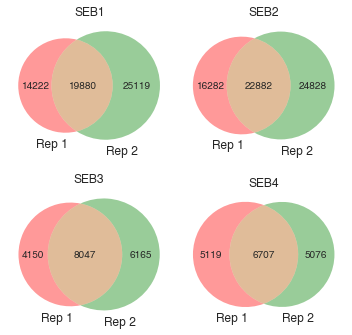

In [29]:
num_rows = 2
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "replicate_plotting.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:

    for x, (name, dfs) in enumerate(df.groupby("encode_id")):
        ax = fig.add_subplot(num_rows, num_cols, x + 1)
        rep1, rep2 = dfs.filtered_peaks
        rep1 = pybedtools.BedTool(rep1)
        rep2 = pybedtools.BedTool(rep2)
        both = rep1.intersect(rep2, u=True, s=True)
        rep1_only = rep1.intersect(rep2, v=True, s=True)
        rep2_only = rep2.intersect(rep1, v=True, s=True)
        venn2({"01": len(rep1_only),
               "10": len(rep2_only),
               "11": len(both)},
              set_labels= ["Rep 1", "Rep 2"],
              ax=ax)
        ax.set_title(name)
        

ok I'll be conservative and take only overlapping peaks for futher analysis, too many that don't overlap to be safe

In [9]:
genes = pybedtools.BedTool("/home/gpratt/clipper/clipper/data/regions/hg19_genes.bed")


merged_peaks = {}
for name, dfs in df.groupby("encode_id"):
        rep1, rep2 = dfs.filtered_peaks
        rep1 = pybedtools.BedTool(rep1)
        rep2 = pybedtools.BedTool(rep2)
        both = rep1.intersect(rep2, u=True, s=True)
        
        #This is a hack, I need to pair down the number of peaks / merge genes eventually
        overlapping_genes = both.intersect(genes, wo=True, s=True).saveas(name + ".merged.bed")

        merged_peaks[name] = overlapping_genes
        
merged_peaks = pd.DataFrame(pd.Series(merged_peaks), columns=['bed_file'])
merged_peaks['stress'] = 's us s us'.split()
merged_peaks['rbp'] = 'g3bp g3bp tia1 tia1'.split()


#How many targets are unique or shared for the two proteins in unstressed conditions?

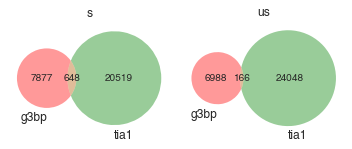

In [22]:
num_rows = 1
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "overlapping_under_stress_peaks.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:

    for x, (name, dfs) in enumerate(merged_peaks.groupby("stress")):
        ax = fig.add_subplot(num_rows, num_cols, x + 1)
        rep1, rep2 = dfs.bed_file
        rep1 = pybedtools.BedTool(rep1)
        rep2 = pybedtools.BedTool(rep2)
        both = rep1.intersect(rep2, u=True, s=True)
        rep1_only = rep1.intersect(rep2, v=True, s=True)
        rep2_only = rep2.intersect(rep1, v=True, s=True)
        venn2({"01": len(rep1_only),
               "10": len(rep2_only),
               "11": len(both)},
              set_labels= [dfs.iloc[0].rbp, dfs.iloc[1].rbp],
              ax=ax)
        ax.set_title(dfs.iloc[0].stress)
        

The overlap of G3BP1 peaks is pretty poor with TIA1 peaks in both stressed and unstressed conditions

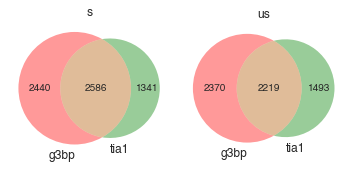

In [23]:
num_rows = 1
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "overlapping_under_stress_genes.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:

    for x, (name, dfs) in enumerate(merged_peaks.groupby("stress")):
        ax = fig.add_subplot(num_rows, num_cols, x + 1)
        rep1, rep2 = dfs.bed_file
        rep1 = pybedtools.BedTool(rep1)
        rep2 = pybedtools.BedTool(rep2)
        rep1 = {interval[9] for interval in rep1}
        rep2 = {interval[9] for interval in rep2}

        venn2([rep1, rep2],
              set_labels= [dfs.iloc[0].rbp, dfs.iloc[1].rbp],
              ax=ax)
        ax.set_title(dfs.iloc[0].stress)

Looks like ~50% of genes / targets overlap.  Probably greather than siginifcant.  Its a pretty distinct subset of genes that are targeted

#how does the target pool for each protein shift upon stress?


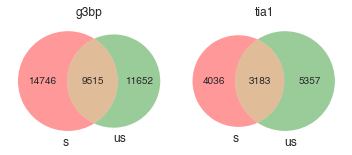

In [24]:
num_rows = 1
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "overlapping_between_stress_peaks.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:

    for x, (name, dfs) in enumerate(merged_peaks.groupby("rbp")):
        ax = fig.add_subplot(num_rows, num_cols, x + 1)
        rep1, rep2 = dfs.bed_file
        rep1 = pybedtools.BedTool(rep1)
        rep2 = pybedtools.BedTool(rep2)
        both = rep1.intersect(rep2, u=True, s=True)
        rep1_only = rep1.intersect(rep2, v=True, s=True)
        rep2_only = rep2.intersect(rep1, v=True, s=True)
        venn2({"01": len(rep1_only),
               "10": len(rep2_only),
               "11": len(both)},
              set_labels= [dfs.iloc[0].stress, dfs.iloc[1].stress],
              ax=ax)
        ax.set_title(dfs.iloc[0].rbp)
        

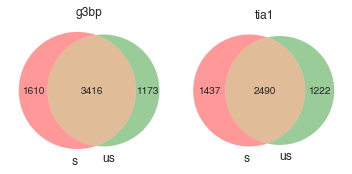

In [25]:
num_rows = 1
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "overlapping_between_stress_genes.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:

    for x, (name, dfs) in enumerate(merged_peaks.groupby("rbp")):
        ax = fig.add_subplot(num_rows, num_cols, x + 1)
        rep1, rep2 = dfs.bed_file
        rep1 = pybedtools.BedTool(rep1)
        rep2 = pybedtools.BedTool(rep2)
        rep1 = {interval[9] for interval in rep1}
        rep2 = {interval[9] for interval in rep2}

        venn2([rep1, rep2],
              set_labels= [dfs.iloc[0].stress, dfs.iloc[1].stress],
              ax=ax)
        ax.set_title(dfs.iloc[0].rbp)

No obvious shift towards increase or decrease of targetting for Peaks or Genes, we can dig into interesting genes later.  Looks like general random noise for shifting, need to do a go analysis on unique sites to really get at this question

In [30]:
merged_peaks

StopIteration: 

StopIteration: 

#if they acquire new targets under stress, are these unique or shared between the proteins?

In [14]:
#get new targets under stress
new_targets = {}
for name, dfs in merged_peaks.groupby("rbp"):
    rep1, rep2 = dfs.bed_file
    stress = pybedtools.BedTool(rep1)
    unstressed = pybedtools.BedTool(rep2)
    new_targets[name] = stress.intersect(unstressed, v=True, s=True)

In [15]:
overlapping_targets = new_targets['g3bp'].intersect(new_targets['tia1'], s=True, u=True)
print len(overlapping_targets)      

304


Fully half of the new targets under stress are bound by both G3BP and TIA1.  This is useful

In [16]:
def gencode_to_ensembl(gene_list):
    for gene in gene_list:
        yield gene.split(".")[0]

In [17]:
hg19go = GO.GO("/projects/ps-yeolab/genomes/hg19/hg19.ENSG_to_GO.txt.gz")

In [18]:
overlapping_genes = {interval[9] for interval in overlapping_targets}


In [19]:
overlapping_genes_go = hg19go.enrichment(gencode_to_ensembl(overlapping_genes))
overlapping_genes_go = overlapping_genes_go[overlapping_genes_go['Bonferroni-corrected Hypergeometric p-Value'] < .05]

/home/gpratt/anaconda/lib/python2.7/site-packages/gscripts-0.1.6-py2.7.egg/gscripts/GO/GO.py:88: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df = df.sort('Bonferroni-corrected Hypergeometric p-Value')


In [26]:
overlapping_genes_go.to_csv(os.path.join(img_dir, "go_analysis.csv"))

In [28]:
overlapping_genes_go.ix['GO:0003723']['Gene symbols in List']

'CELF1,PUM2,SETD1B,HNRNPH1,RPS2,HNRNPH3,LARP4,TROVE2,XPO1,QKI,NONO,EIF1AX,SON,HNRNPK,HNRNPA2B1,PTBP1,IREB2,DCP2,DDX3X,ZFP36L2,MEX3C,DAZAP1,DIS3,EIF4G2,SPEN,THUMPD1,NCL,G3BP2'

In [27]:
overlapping_genes_go.ix['GO:0008380']['Gene symbols in List']

'DDX23,YTHDC1,QKI,THRAP3,CDK12,SF3B1,PPP4R2,SON,NONO,HNRNPK,HNRNPH1,WBP11,HNRNPH3,PTBP1,SMC1A,HNRNPA2B1'